In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
def followers_MVO(r, Q, Z, ub):
    # r (nx1), Q(nxn), Z (1x1) ub(nx1)

    n = len(r)
    lb = np.zeros(n)
    Aeq = np.ones([1, n])
    beq = 1

    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, Q)),
                       [r.T @ x >= Z,
                       Aeq @ x == beq,
                       x >= lb,
                       x <= ub])
    prob.solve(verbose=False, solver=cp.ECOS)

    y = np.array([z if z > 0.01 else 0 for z in x.value])
    return y

In [3]:
def plot_portfolios(portfolio):
    trader = {0: "Financials", 1: "Information Technology", 2: "Consumer Staples"}
    plt.subplots(nrows=1, ncols=4,figsize=(25, 5))

    all_tickers = []
    all_weights = []

    for i in portfolio:
        ax = plt.subplot(1, 4, i+1)
        plt.pie(portfolio[i].values(), labels=portfolio[i].keys())
        ax.set_title(f"{trader[i]} Trader Distribution")

        all_tickers.extend(portfolio[i].values())
        all_weights.extend(portfolio[i].keys())

    ax = plt.subplot(1, 4, 4)
    plt.pie(all_tickers, labels=all_weights)
    ax.set_title(f"Firm Distribution")

In [4]:
full_prices = pd.read_csv("../data/Equity_Prices_Full.csv", index_col=0)
full_prices.index = pd.to_datetime(full_prices.index)

sectors = {"Financials": ["ALL", "BAC", "C", "GS", "JPM"],
           "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
           "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]}

tickers = np.ndarray.flatten(np.array(list(sectors.values())))
n = len(tickers)

full_prices = full_prices[tickers]

In [5]:
strategies = {} #key is trader ID, value is ub array (1 if allowed to invest)

strategies[0] = [1 if ticker in sectors["Financials"] else 0 for ticker in tickers]
strategies[1] = [1 if ticker in sectors["Information Technology"] else 0 for ticker in tickers]
strategies[2] = [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in tickers]

In [6]:
subset_start_date = "2010-01-01"
subset_date = "2012-12-31"

subset_prices = full_prices.loc[subset_start_date:subset_date]
subset_returns = subset_prices.pct_change(1).iloc[1:, :]

training_returns = subset_returns.iloc[:-1,:]
test_returns = subset_returns.iloc[-1,:]

In [7]:
r = gmean(training_returns + 1) -1
Q = np.cov(training_returns.T)

assert r.shape == (n,)
assert Q.shape == (n,n)


Projected minimum gain: 180.0
Actual gain: 113.77715738624303
Portfolio risk: 0.03642881213951104


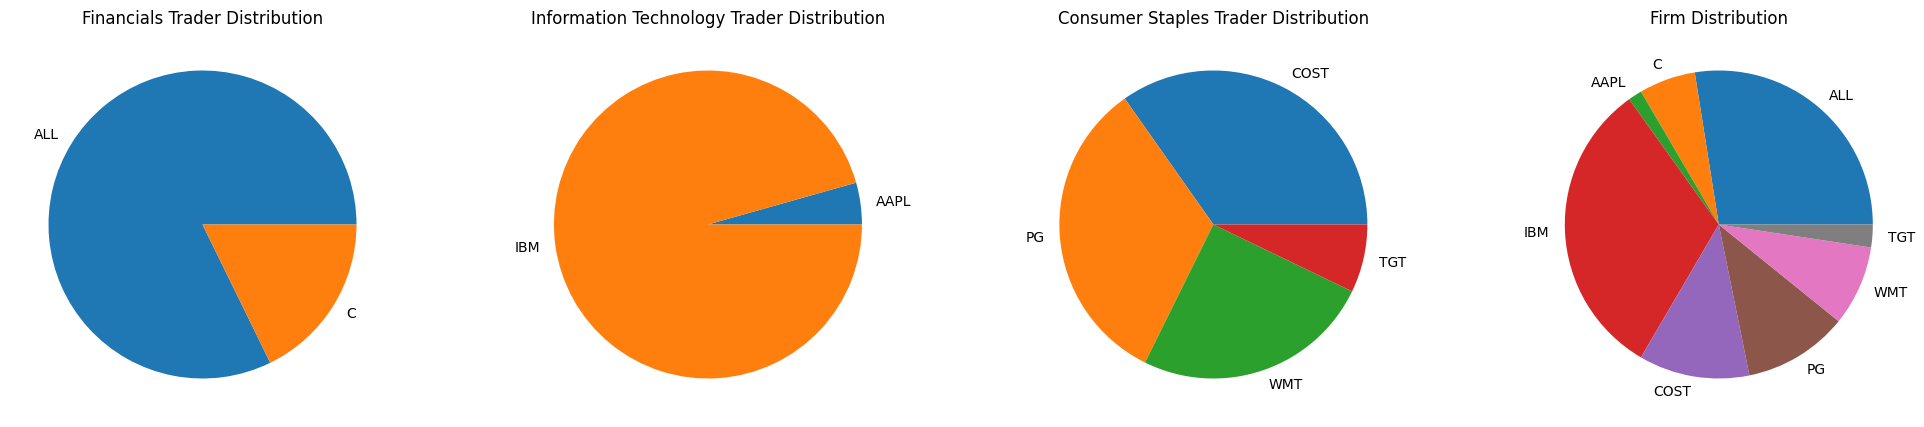

In [8]:
B = np.array([8000, 1000, 1000])
V = np.array([0.02, 0.01, 0.01])

overall_holdings = np.zeros(n)
total = 0

portfolio = {}

for i in range(3):
    x = followers_MVO(r, Q, V[i], strategies[i])

    portfolio[i] = {tickers[index]:weight for index, weight in enumerate(x) if weight}
    overall_holdings += (B[i]*x)

projected_gain = sum(B*V)
actual_gain = test_returns.T @ overall_holdings

risk = (overall_holdings @ Q @ overall_holdings)/(sum(B)**2)

print(f"Projected minimum gain: {projected_gain}")
print(f"Actual gain: {actual_gain}")
print(f"Portfolio risk: {risk}")

plot_portfolios(portfolio)